In [1]:
import math
import multiprocessing
import os
from functools import partial
from pathlib import Path
from typing import Any, List, Optional, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import yaml
from dotenv import load_dotenv
from tqdm import tqdm

In [2]:
load_dotenv(".env", override=True)
if Path(".env.local").exists():
  load_dotenv(".env.local", override=True)

Used environment variables:
- `DATASETS_DIRPATH`: Datasets desination directory path.
- `TMP_DIRPATH`: Temporary directory path.

In [3]:
tmp_dirpath = Path(os.environ["TMP_DIRPATH"]).resolve()
datasets_dirpath = Path(os.environ["DATASETS_DIRPATH"]).resolve()

# Prepare

In [4]:
# list of zip files to download (train / test datasets) (zipfile, csv entry point relative file path)
train_archives = [
    ("LARD_train_BIRK_LFST.zip", "LARD_train_BIRK_LFST.csv"),
    ("LARD_train_DAAG_DIAP.zip", "LARD_train_DAAG_DIAP.csv"),
    ("LARD_train_KMSY.zip", "LARD_train_KMSY.csv"),
    ("LARD_train_LFMP_LFPO.zip", "LARD_train_LFMP_LFPO.csv"),
    ("LARD_train_LFQQ.zip", "LARD_train_LFQQ.csv"),
    ("LARD_train_LPPT_SRLI.zip", "LARD_train_LPPT_SRLI.csv"),
    ("LARD_train_VABB.zip", "LARD_train_VABB.csv"),
]
valid_archives = [
    ("LARD_test_real.zip", "LARD_test_real_nominal/Test_Real_Nominal.csv"),
    ("LARD_test_real.zip", "LARD_test_real_edge_cases/Test_Real_Edge_Cases.csv"),
    ("LARD_test_synth.zip", "LARD_test_synth.csv"),
]

Main processing functions:

In [5]:
def process(dataset: str, new_image_shape: Optional[Tuple[int, int]], dest_dirpath: Path, sample: Tuple[int, List[Any]]) -> None:
    """Parallel processing function.

    Args:
        dataset (str): Dataset ("train" / "valid").
        new_image_shape (Optional[Tuple[int, int]]): New image shape after resize, if specified.
        dest_dirpath (Path): Where to store processed data.
        sample (Tuple[int, List[Any]]): Index and dataset sample to process.
    """

    index, row = sample

    # get image and read it
    image_filepath = row['images_dirpath'] / row['image'].replace('\\', '/')
    image = np.array(cv2.cvtColor(cv2.imread(image_filepath.as_posix()), cv2.COLOR_BGR2RGB))
    # crop watermark
    watermark_height = row["watermark_height"]
    if not math.isnan(watermark_height):
        watermark_height = int(watermark_height)
        image = image[watermark_height:-watermark_height, :, :]
    height, width, _ = image.shape
    if new_image_shape is None:
        new_image_shape = [width, height]
    # resize image and save it
    new_image_filepath = dest_dirpath / 'images' / dataset / f"{index:06d}.jpg"
    if new_image_shape[1] != image.shape[0] or new_image_shape[0] != image.shape[1]:
        image = cv2.resize(image, new_image_shape, interpolation = cv2.INTER_NEAREST)
    os.makedirs(new_image_filepath.parent, exist_ok=True)
    cv2.imwrite(new_image_filepath.as_posix(), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    # process labels (cx, cy, w, h) normalized
    # A: top-left
    # B: top-right
    # C: bottom-left
    # D: bottom-right
    x = np.array([row[f"x_{k}"] for k in "ABDC"], dtype=np.float32)
    y = np.array([row[f"y_{k}"] for k in "ABDC"], dtype=np.float32)
    watermark_height = row["watermark_height"]
    if not math.isnan(watermark_height):
        y -= watermark_height
        # height -= 2 * watermark_height
    x = np.clip(x, 0.0, width) / width * new_image_shape[0]
    y = np.clip(y, 0.0, height) / height * new_image_shape[1]

    # bbox
    x_min = float(x.min())
    x_max = float(x.max())
    y_min = float(y.min())
    y_max = float(y.max())
    w = x_max - x_min
    h = y_max - y_min
    cx = x_min + w/2.0
    cy = y_min + h/2.0
    bbox = [cx, cy, w, h]
    bbox[0] /= new_image_shape[0]
    bbox[1] /= new_image_shape[1]
    bbox[2] /= new_image_shape[0]
    bbox[3] /= new_image_shape[1]

    # save labels
    label_filepath = dest_dirpath / "detect" / "labels" / dataset / f"{new_image_filepath.stem}.txt"
    os.makedirs(label_filepath.parent, exist_ok=True)
    dest_new_image_filepath = dest_dirpath / "detect" / "images" / dataset / new_image_filepath.name
    os.makedirs(dest_new_image_filepath.parent, exist_ok=True)
    os.symlink(new_image_filepath.as_posix(), dest_new_image_filepath.as_posix(), target_is_directory=False)
    with open(label_filepath.as_posix(), 'w') as f:
        f.write('%g %.6f %.6f %.6f %.6f\n' % (0, *bbox))

    # segmentation
    keypoints = (np.stack((x, y), axis=-1) / np.array(new_image_shape)).reshape(-1).tolist()
    label_filepath = dest_dirpath / "segment" / "labels" / dataset / f"{new_image_filepath.stem}.txt"
    os.makedirs(label_filepath.parent, exist_ok=True)
    dest_new_image_filepath = dest_dirpath / "segment" / "images" / dataset / new_image_filepath.name
    os.makedirs(dest_new_image_filepath.parent, exist_ok=True)
    os.symlink(new_image_filepath.as_posix(), dest_new_image_filepath.as_posix(), target_is_directory=False)
    with open(label_filepath.as_posix(), 'w') as f:
        f.write("0 "+" ".join(['%.6f' % p for p in keypoints])+"\n")

    # pose (only runway bottom threshold)
    keypoints = np.stack((x[-1:-3:-1], y[-1:-3:-1]), axis=-1) / np.array(new_image_shape)
    kpts = []
    for k in keypoints.tolist():
        kpts += (k + [1,])
    label_filepath = dest_dirpath / "pose" / "labels" / dataset / f"{new_image_filepath.stem}.txt"
    os.makedirs(label_filepath.parent, exist_ok=True)
    dest_new_image_filepath = dest_dirpath / "pose" / "images" / dataset / new_image_filepath.name
    os.makedirs(dest_new_image_filepath.parent, exist_ok=True)
    os.symlink(new_image_filepath.as_posix(), dest_new_image_filepath.as_posix(), target_is_directory=False)
    with open(label_filepath.as_posix(), 'w') as f:
        f.write("0 "+" ".join(['%.6f' % p for p in bbox+kpts])+"\n")

def start(dataset: str, archives: List[str], raw_dirpath: Path, new_image_shape: Optional[Tuple[int, int]], dest_dirpath: Path):
    """Start dataset generation

    Args:
        dataset (str): Dataset to be processed ("train" / "valid").
        archives (List[str]): List of archives file names.
        raw_dirpath (Path): Directory path where the archives had been unzipped.
        new_image_shape (Optional[Tuple[int, int]]): Resized image shape.
        dest_dirpath (Path): Directory path where the final dataset will be hosted.
    """
    # get csv filepaths in unzipped archives
    csv_filepaths = [raw_dirpath / archive.rpartition('.')[0] / csv_relfilepath for archive, csv_relfilepath in archives]
    # read csv and concat them
    dfs = []
    for csv_filepath in csv_filepaths:
        # read csv file
        dfi = pd.read_csv(csv_filepath.as_posix(), delimiter=';')
        # append dirpath where images are stored for this chunk
        dfi["images_dirpath"] = csv_filepath.parent
        dfs.append(dfi)
    df = pd.concat(dfs).reset_index(drop=True)
    # start parallel processing
    total = len(df)
    with multiprocessing.Pool(os.cpu_count()) as pool:
        list(pool.imap(partial(process, dataset, new_image_shape, dest_dirpath), tqdm(df.iterrows(), total=total)))
    # for i in tqdm(df.iterrows(), total=total):
    #     partial(process, dataset, new_image_shape, dest_dirpath)(i)

def build(dataset_name: str, new_image_shape: Optional[Tuple[int, int]], tasks: List[str] = ["detect", "segment", "pose"]) -> Path:
    """Build dataset.

    Args:
        dataset_name (str): Name of the generated dataset.
        new_image_shape (Tuple[int, int]): Resized image shape.
        tasks: (List[str]): Tasks to consider for generation ("detect", "segment" and/or "pose").

    Returns:
        Path: Directory path to generated dataset.
    """
    dest_dirpath = datasets_dirpath / dataset_name
    if dest_dirpath.exists():
        print(f"Warning: destination directory path already exists: {dest_dirpath.as_posix}")
        return dest_dirpath
    os.makedirs(dest_dirpath.as_posix(), exist_ok=True)

    print("Process train dataset ...")
    start("train", train_archives, tmp_dirpath, new_image_shape, dest_dirpath)

    print("Process valid dataset ...")
    start("valid", valid_archives, tmp_dirpath, new_image_shape, dest_dirpath)

    print("Create dataset file ...")
    for task in tasks:
        d = {'path': (dest_dirpath / task).as_posix(),
            'train': "images/train",
            'val': "images/valid",
            'test': "",
            'names': {
                0: "runway"
            }}  # dictionary
        if task in ["pose"]:
            d["kpt_shape"] = [2, 3]
        with open((dest_dirpath / task / "dataset.yaml").as_posix(), 'w') as f:
            yaml.dump(d, f, sort_keys=False)

    return dest_dirpath

Generation entry point:

In [6]:
build("origin", None)

Process train dataset ...


100%|██████████| 12212/12212 [06:29<00:00, 31.34it/s]


Process valid dataset ...


100%|██████████| 4023/4023 [01:56<00:00, 34.54it/s]


Create dataset file ...


PosixPath('/mnt/confiance/common/UC_Data_Folder/UC_Airbus_Runway_Detection/data/origin')

Drawing function to check a generated sample:

In [7]:
def draw_detect(label_filepath: Path, scale=0.5):
    sample = pd.read_csv(label_filepath.as_posix(), delimiter=" ", header=None)
    bbox = sample.iloc[0].to_numpy()[1:]

    image_filepath = Path(label_filepath.as_posix().replace("/labels/", "/images/"))
    image_filepath = image_filepath.parent / (image_filepath.stem + ".jpg")
    image = np.array(cv2.cvtColor(cv2.imread(image_filepath.as_posix()), cv2.COLOR_BGR2RGB))
    height, width, depth = image.shape
    bbox[0] *= width
    bbox[1] *= height
    bbox[2] *= width
    bbox[3] *= height
    bbox_xyxy = [
        bbox[0] - bbox[2] / 2.,
        bbox[1] - bbox[3] / 2.,
        bbox[0] + bbox[2] / 2.,
        bbox[1] + bbox[3] / 2.,
    ]
    image = cv2.rectangle(image, (int(bbox_xyxy[0]), int(bbox_xyxy[1])), (int(bbox_xyxy[2]), int(bbox_xyxy[3])), color=(255, 0, 0), thickness=3)

    dpi = 100
    fig, ax = plt.subplots(1, 1, figsize=(int(width/dpi*scale), int(height/dpi*scale)), dpi=dpi)
    ax.imshow(image)
    ax.axis("off")

def draw_segment(label_filepath: Path, scale=0.5):
    sample = pd.read_csv(label_filepath.as_posix(), delimiter=" ", header=None)
    keypoints = sample.iloc[0].to_numpy()[1:].reshape(-1, 2)

    image_filepath = Path(label_filepath.as_posix().replace("/labels/", "/images/"))
    image_filepath = image_filepath.parent / (image_filepath.stem + ".jpg")
    image = np.array(cv2.cvtColor(cv2.imread(image_filepath.as_posix()), cv2.COLOR_BGR2RGB))
    height, width, depth = image.shape
    keypoints = keypoints[:,:2] * np.array([width, height])
    image_masked = image.copy()
    image_masked = cv2.fillPoly(image_masked, pts = np.int32(keypoints[np.newaxis,:]), color=(255, 0, 0))
    cv2.addWeighted(image, 0.6, image_masked, 0.4, 0, image_masked)

    dpi = 100
    fig, ax = plt.subplots(1, 1, figsize=(int(width/dpi*scale), int(height/dpi*scale)), dpi=dpi)
    ax.imshow(image_masked)
    ax.axis("off")

def draw_pose(label_filepath: Path, scale=0.5):
    sample = pd.read_csv(label_filepath.as_posix(), delimiter=" ", header=None)
    bbox = sample.iloc[0].to_numpy()[1:5]
    keypoints = sample.iloc[0].to_numpy()[5:].reshape(-1, 3)

    image_filepath = Path(label_filepath.as_posix().replace("/labels/", "/images/"))
    image_filepath = image_filepath.parent / (image_filepath.stem + ".jpg")
    image = np.array(cv2.cvtColor(cv2.imread(image_filepath.as_posix()), cv2.COLOR_BGR2RGB))
    height, width, depth = image.shape

    dpi = 100

    visible = keypoints[:,2] == 1
    keypoints = keypoints[:,:2] * np.array([width, height])
    colors = px.colors.sample_colorscale("plasma", [n/(len(keypoints)-1) for n in range(len(keypoints))], colortype='tuple')
    for v, keypoint, color in zip(visible, keypoints, colors):
        if v:
            image = cv2.circle(image, center=np.int32(keypoint), radius=max(2, int(width/dpi*scale)), color=[int(i*255) for i in color], thickness=-1)

    bbox[0] *= width
    bbox[1] *= height
    bbox[2] *= width
    bbox[3] *= height
    bbox_xyxy = [
        bbox[0] - bbox[2] / 2.,
        bbox[1] - bbox[3] / 2.,
        bbox[0] + bbox[2] / 2.,
        bbox[1] + bbox[3] / 2.,
    ]
    image = cv2.rectangle(image, (int(bbox_xyxy[0]), int(bbox_xyxy[1])), (int(bbox_xyxy[2]), int(bbox_xyxy[3])), color=(255, 0, 0), thickness=3)

    fig, ax = plt.subplots(1, 1, figsize=(int(width/dpi*scale), int(height/dpi*scale)), dpi=dpi)
    ax.imshow(image)
    ax.axis("off")

def draw_samples(dataset_dirpath: Path, file: str):
    """Draw some samples of a YOLO format dataset.

    Args:
        dataset_dirpath (Path): Dataset directory path.
        resolution (Tuple[int, int]): Resolution of images.
    """
    if (dataset_dirpath / "detect").exists():
        draw_detect(dataset_dirpath / "detect" / file)
    if (dataset_dirpath / "segment").exists():
        draw_segment(dataset_dirpath / "segment" / file)
    if (dataset_dirpath / "pose").exists():
        draw_pose(dataset_dirpath / "pose" / file)

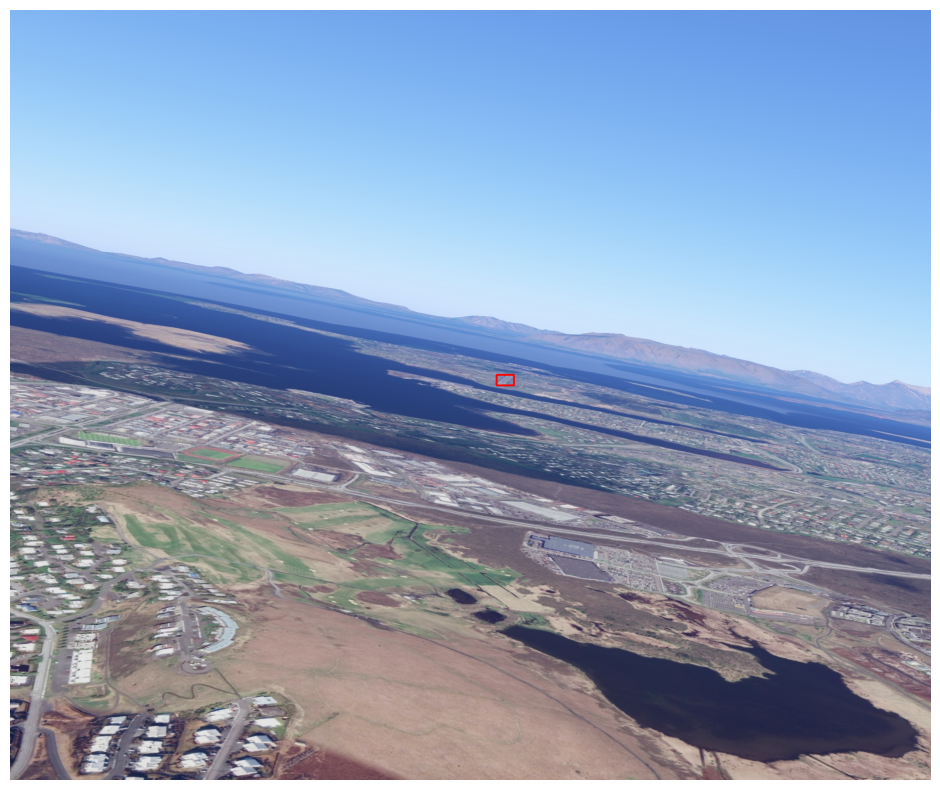

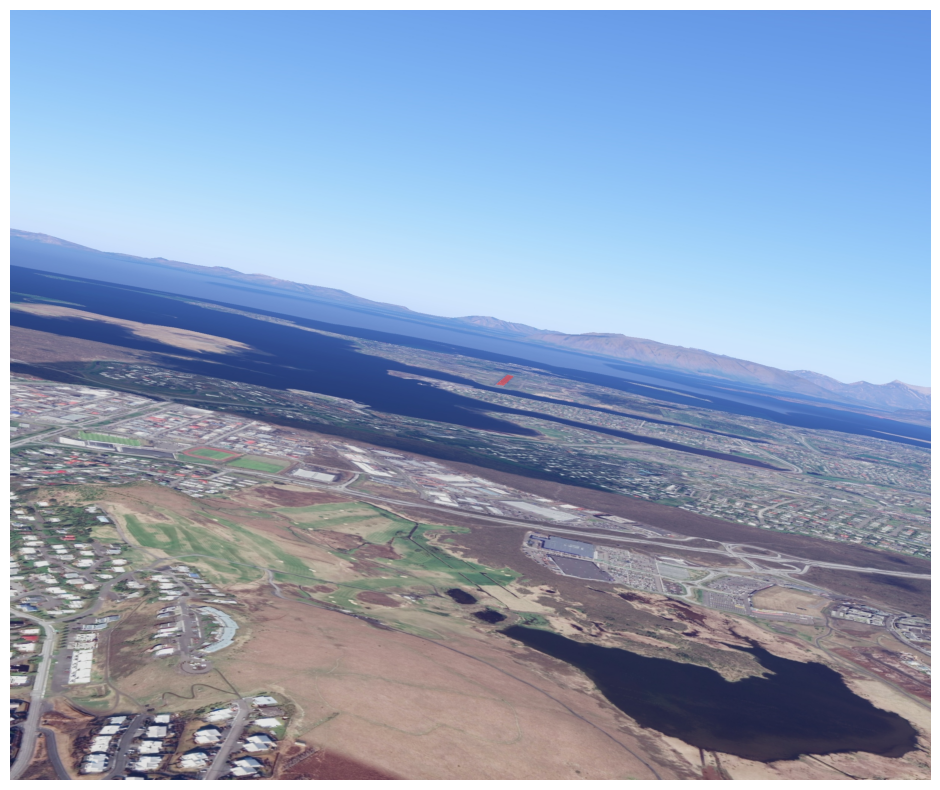

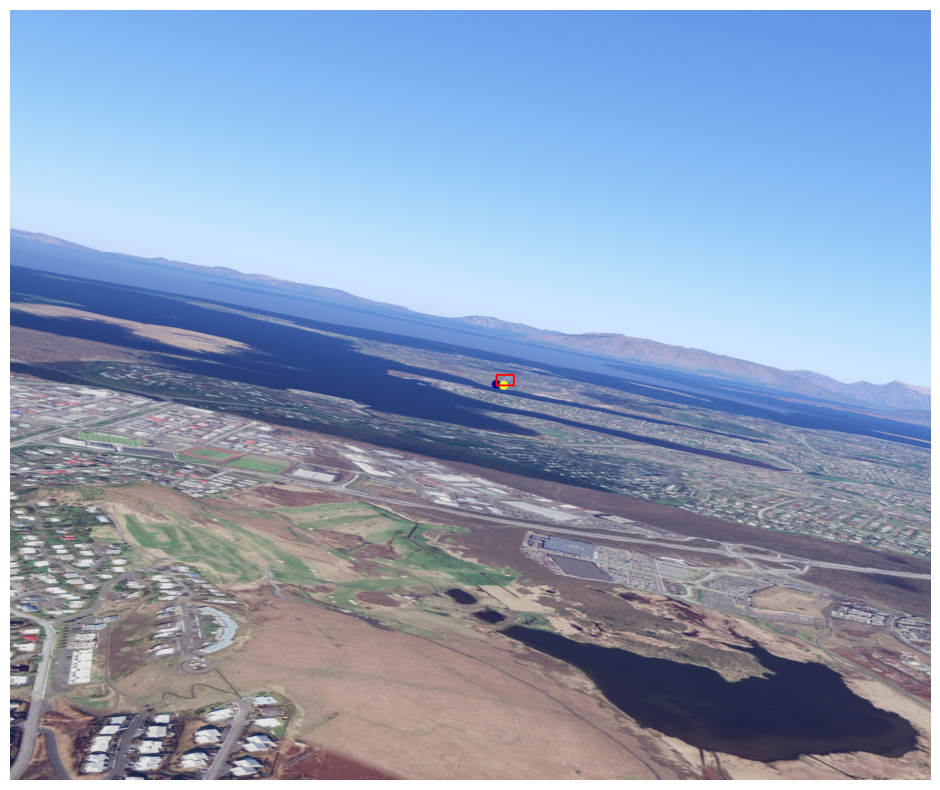

In [8]:
draw_samples(datasets_dirpath / "origin", "labels/train/000000.txt")